<a href="https://colab.research.google.com/github/MithilaCoomaraswamy/DSGP/blob/Period-Tracker/PeriodTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PeriodData.csv')
np.random.seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

In [ ]:
df = df.drop(['CycleWithPeakorNot', 'FirstDayofHigh', 'TotalNumberofHighDays', 'Age', 'BMI', 'TotalHighPostPeak', 'TotalNumberofPeakDays', 'TotalDaysofFertility',	'TotalFertilityFormula', 'ReproductiveCategory', 'Group', 'NumberofDaysofIntercourse',	'IntercourseInFertileWindow', 'IntercourseDuringUnusBleed', 'AgeM',	'Maristatus',	'MaristatusM',	'Yearsmarried',	'Wedding',	'Religion',	'ReligionM',	'Ethnicity',	'EthnicityM',	'Schoolyears',	'SchoolyearsM',	'OccupationM',	'IncomeM',	'Height',	'Weight',	'Reprocate',	'Numberpreg',	'Livingkids',	'Miscarriages',	'Abortions',	'Medvits',	'Medvitexplain',	'Gynosurgeries',	'LivingkidsM',	'Boys',	'Girls',	'MedvitsM',	'MedvitexplainM',	'Urosurgeries',	'Breastfeeding',	'Method',	'Prevmethod',	'Methoddate',	'Whychart',	'Nextpreg',	'NextpregM',	'Spousesame',	'SpousesameM',	'Timeattemptpreg', 'MeanBleedingIntensity',	'UnusualBleeding',	'PhasesBleeding', 'MensesScoreDayOne',	'MensesScoreDayTwo',	'MensesScoreDayThree',	'MensesScoreDayFour',	'MensesScoreDayFive',	'MensesScoreDaySix',	'MensesScoreDaySeven',	'MensesScoreDayEight',	'MensesScoreDayNine',	'MensesScoreDayTen',	'MensesScoreDay11',	'MensesScoreDay12',	'MensesScoreDay13',	'MensesScoreDay14',	'MensesScoreDay15',	'TotalMensesScore'], axis = 1)

In [ ]:
df.insert(2, "FirstDayofCurrentPeriod", None)

In [ ]:
df.loc[df['CycleNumber'] == 1, 'FirstDayofCurrentPeriod'] = pd.to_datetime('2021-01-01')

# For subsequent cycles, calculate the FirstDayofCurrentPeriod based on the previous cycle's length
for i in range(2, df['CycleNumber'].max() + 1):
    # For each client, calculate the FirstDayofCurrentPeriod for this cycle
    for client_id in df['ClientID'].unique():
        # Get the previous cycle's data for this client
        prev_cycle = df[(df['ClientID'] == client_id) & (df['CycleNumber'] == i - 1)]

        if not prev_cycle.empty:
            # Add LengthofCycle of the previous cycle to calculate the FirstDay for the current cycle
            prev_first_day = prev_cycle['FirstDayofCurrentPeriod'].values[0]
            cycle_length = prev_cycle['LengthofCycle'].values[0]
            df.loc[(df['ClientID'] == client_id) & (df['CycleNumber'] == i), 'FirstDayofCurrentPeriod'] = prev_first_day + pd.to_timedelta(cycle_length, unit='D')


In [ ]:
df['MeanCycleLength'] = df.groupby('ClientID')['MeanCycleLength'].transform('first')
df['MeanMensesLength'] = df.groupby('ClientID')['MeanMensesLength'].transform('first')

In [ ]:
df =df.replace(' ', np.nan)

In [ ]:
df.infer_objects(copy=False)

In [ ]:
columns_to_convert = ['MeanCycleLength', 'EstimatedDayofOvulation',	'LengthofLutealPhase',	'LengthofMenses',	'MeanMensesLength']
for col in columns_to_convert:
               df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
df['LengthofMenses'].interpolate(method='linear', inplace=True)

In [ ]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

In [ ]:
df.dropna(subset=['MeanMensesLength'], inplace=True)

In [ ]:
def fill_missing_menses_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanMensesLength' is missing (NaN), calculate the mean of 'LengthofMenses'
        if group['MeanMensesLength'].isnull().any():
            mean_menses_length = group['LengthofMenses'].mean()

            # Fill missing MeanMensesLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanMensesLength'] = df.loc[df['ClientID'] == client_id, 'MeanMensesLength'].fillna(mean_menses_length)

    return df

In [ ]:
df = fill_missing_menses_length(df)

In [ ]:
def fill_missing_cycle_length(df):
    # Group by ClientID to process each unique ClientID
    for client_id, group in df.groupby('ClientID'):
        # If 'MeanCycleLength' is missing (NaN), calculate the mean of 'LengthofCycle'
        if group['MeanCycleLength'].isnull().any():
            mean_cycle_length = group['LengthofCycle'].mean()

            # Fill missing MeanCycleLength with the calculated mean
            df.loc[df['ClientID'] == client_id, 'MeanCycleLength'] = df.loc[df['ClientID'] == client_id, 'MeanCycleLength'].fillna(mean_cycle_length)

    return df

In [ ]:
df = fill_missing_cycle_length(df)

In [ ]:
def fill_missing_luteal_phase(df):
    # Loop through each unique ClientID and calculate mean Luteal Phase length
    for client_id, group in df.groupby('ClientID'):
        # Calculate the mean of the existing Luteal Phase lengths for this ClientID
        mean_luteal_phase = group['LengthofLutealPhase'].mean()

        # If the mean Luteal Phase is not NaN, fill missing values with the mean
        if not pd.isna(mean_luteal_phase):
            df.loc[df['ClientID'] == client_id, 'LengthofLutealPhase'] = df.loc[df['ClientID'] == client_id, 'LengthofLutealPhase'].fillna(mean_luteal_phase)

    return df

In [ ]:
df = fill_missing_luteal_phase(df)

In [ ]:
def fill_missing_ovulation_day(df):
    # Loop through each unique ClientID and calculate mean Estimated Day of Ovulation
    for client_id, group in df.groupby('ClientID'):
        # Calculate the mean of the existing EstimatedDayofOvulation values for this ClientID
        mean_ovulation_day = group['EstimatedDayofOvulation'].mean()

        # If the mean is not NaN, fill missing values with the mean for the current ClientID
        if not pd.isna(mean_ovulation_day):
            df.loc[df['ClientID'] == client_id, 'EstimatedDayofOvulation'] = df.loc[df['ClientID'] == client_id, 'EstimatedDayofOvulation'].fillna(mean_ovulation_day)

    return df

In [ ]:
df = fill_missing_ovulation_day(df)

In [ ]:
df = df.dropna()

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
display(df)

There are no duplicate values

Outliers are kept to check for irregular periods

In [ ]:
for cols in df.columns[-6:]:
    sns.boxplot(data=df[cols] ,orient= "h")
    plt.show()

In [ ]:
y = df["EstimatedDayofOvulation"]
x = df.drop(["EstimatedDayofOvulation", "ClientID", "FirstDayofCurrentPeriod"], axis=1)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
x = scaler.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)


In [ ]:
# Predict the next period start date
y_pred = model.predict(x_test)

# Convert predictions to a pandas Series for easier handling
y_pred_series = pd.Series(y_pred)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
simple_reg= xgb.XGBRegressor(objective="reg:squarederror", seeds= 123)
simple_reg.fit(x_train,y_train)

y_pred = simple_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

1.0295216633662656


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:03:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "seeds" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

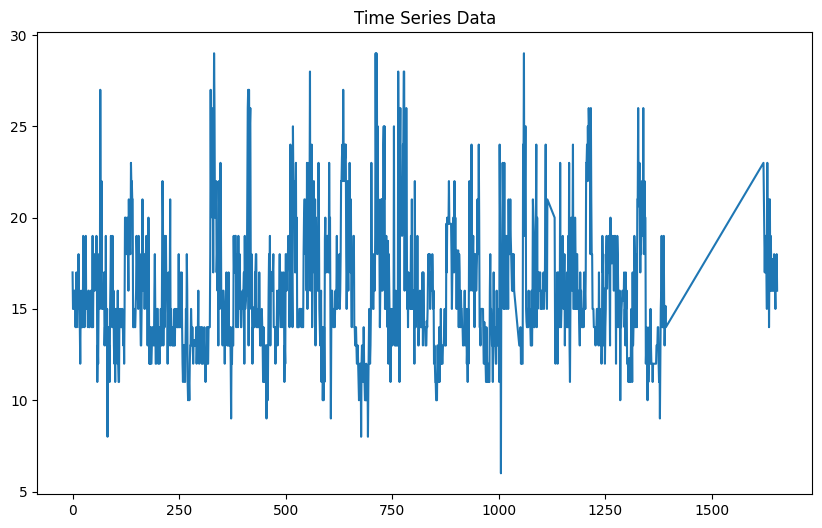

In [ ]:
df['EstimatedDayofOvulation'].plot(figsize=(10,6))
plt.title('Time Series Data')
plt.show()

In [ ]:
result = adfuller(df['EstimatedDayofOvulation'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.453167854479116
p-value: 1.6414403834505373e-13


In [ ]:
# Apply differencing to make the series stationary
df['diff'] = df['EstimatedDayofOvulation'].diff().dropna()

# Check stationarity again using ADF test on the differenced series
result = adfuller(df['diff'].dropna())
print(f"ADF Statistic (Differenced): {result[0]}")
print(f"p-value (Differenced): {result[1]}")


ADF Statistic (Differenced): -15.160857719546623
p-value (Differenced): 6.593824706965359e-28


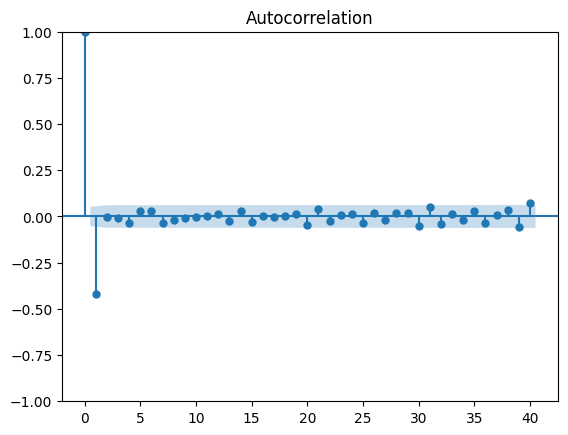

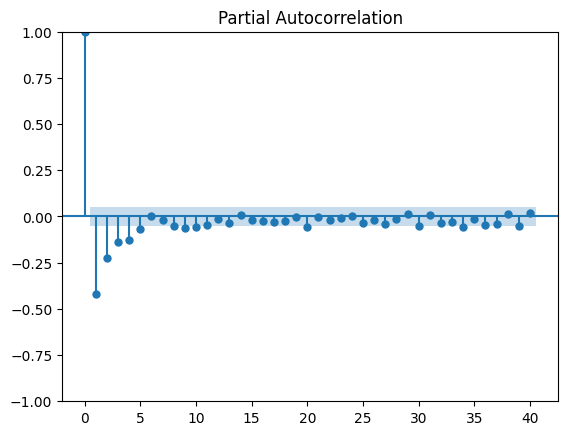

In [ ]:
plot_acf(df['diff'].dropna(), lags=40)  # ACF plot (for MA order)
plot_pacf(df['diff'].dropna(), lags=40)  # PACF plot (for AR order)
plt.show()

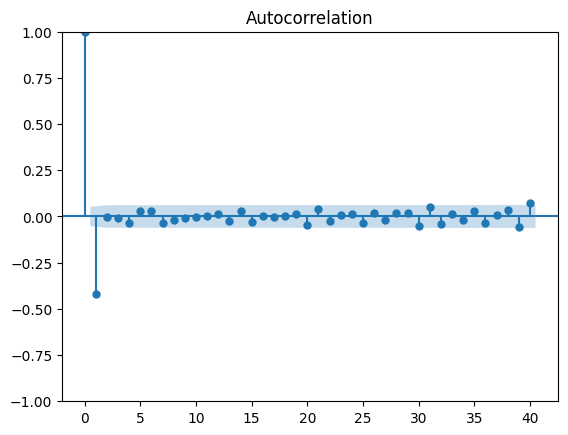

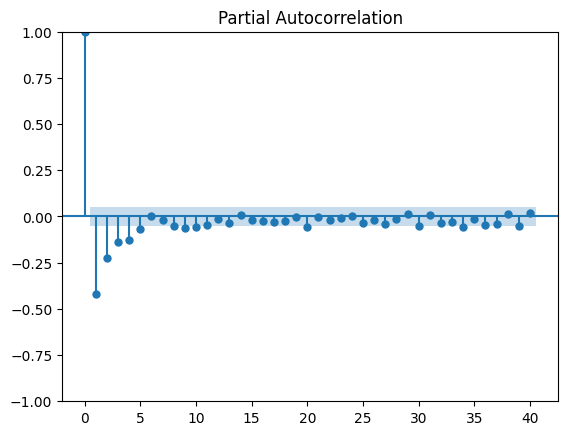

In [ ]:
plot_acf(df['diff'].dropna(), lags=40)  # ACF plot (for MA order)
plot_pacf(df['diff'].dropna(), lags=40)  # PACF plot (for AR order)
plt.show()

In [ ]:
# p, d, q are the AR, I, MA parameters you get from ACF/PACF analysis
# For example: p=1, d=1, q=1

model = ARIMA(df['EstimatedDayofOvulation'], order=(1, 1, 1))  # (p, d, q)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     EstimatedDayofOvulation   No. Observations:                 1394
Model:                      ARIMA(1, 1, 1)   Log Likelihood               -3358.594
Date:                     Mon, 18 Nov 2024   AIC                           6723.188
Time:                             01:03:12   BIC                           6738.906
Sample:                                  0   HQIC                          6729.065
                                    - 1394                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0949      0.035      2.678      0.007       0.025       0.164
ma.L1         -0.6700      0.027    -25.259      0.000      -0.722      -0.618
sigma2      

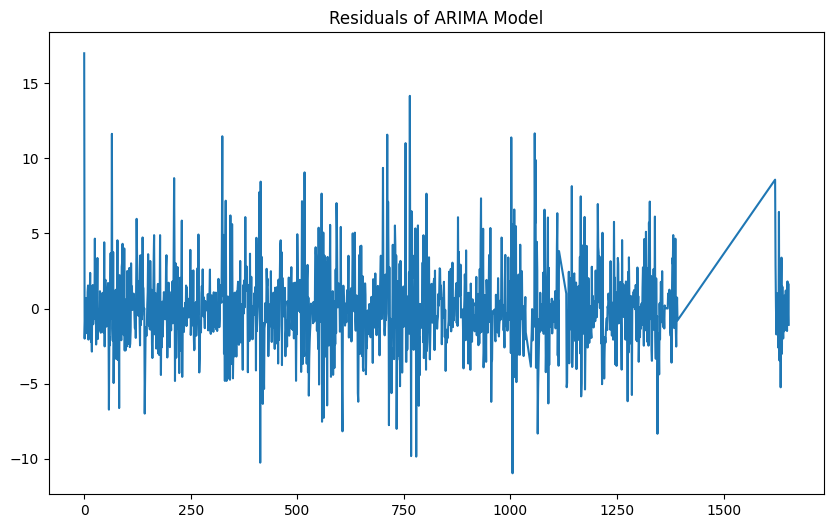

<Figure size 1000x600 with 0 Axes>

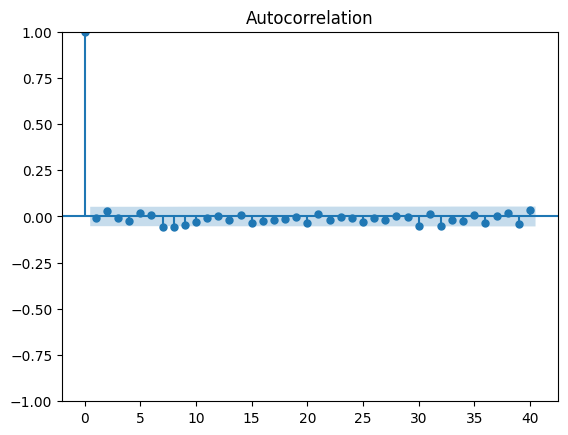

In [ ]:
# Residual plot
residuals = fitted_model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.show()

# Check if residuals resemble white noise (no pattern)
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


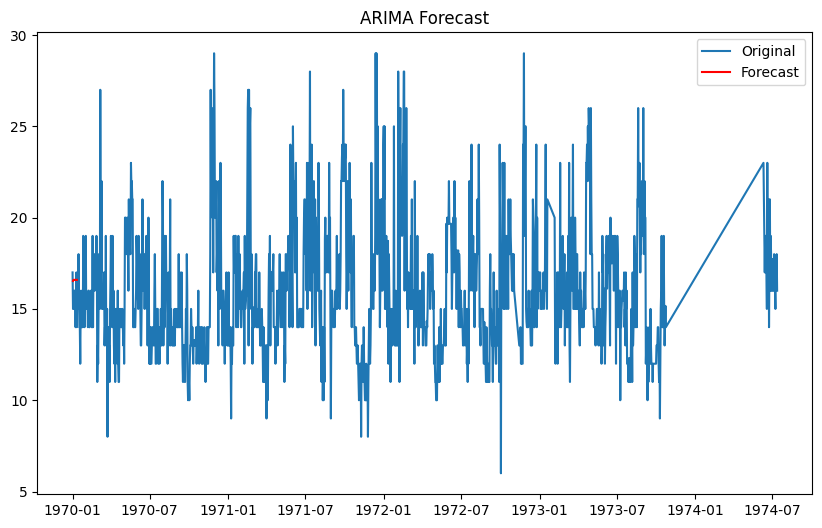

In [ ]:
# Forecasting the next 10 periods (steps)
forecast_steps = 10
forecast = fitted_model.forecast(steps=forecast_steps)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['EstimatedDayofOvulation'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecast', color='red')
plt.legend()
plt.title("ARIMA Forecast")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assume y_test is your true test values (future values)
y_pred = fitted_model.forecast(steps=len(y_test))

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 2.8208090672362265
RMSE: 3.5435911274928595


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
